# 1. Import required Libraries

In [ ]:
import pandas as pd
import numpy as np
import io 

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. Import dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/dataset_2_2.csv', encoding='latin-1')

In [ ]:
df.head()

,Unnamed: 0,Location,Text,Sentiment,Likes,quotes,replies,retweet
0,0,NewYork,Woke criminal New York Times brings back Covid...,Negative,1.0,0.0,1.0,0.0
1,1,NewYork,He proven New York liberal narcissist hired wo...,Negative,1.0,0.0,0.0,0.0
2,2,NewYork,CBS2 News At 11 New York leader say mask vacci...,Neutral,5.0,0.0,0.0,3.0
3,3,NewYork,Pediatric COVID Deaths New York,Neutral,3.0,0.0,0.0,1.0
4,4,NewYork,The 7 day rolling average new Covid hospitaliz...,Negative,2.0,0.0,0.0,0.0


In [ ]:
df.shape

(389603, 8)

# 3. Dataset Pre Processing

In [ ]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
sent_dict = {
    'Neutral':1,
    'Negative':0,
    'Positive':2
}

In [ ]:
df = df[['Text','Sentiment', 'Location']]

In [ ]:
df['Sentiment'].value_counts()

Neutral     144366
Negative    132071
Positive    113166
Name: Sentiment, dtype: int64

In [ ]:
df['Sentiment'] = df['Sentiment'].map(sent_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df.head()

,Text,Sentiment,Location
0,Woke criminal New York Times brings back Covid...,0,NewYork
1,He proven New York liberal narcissist hired wo...,0,NewYork
2,CBS2 News At 11 New York leader say mask vacci...,1,NewYork
3,Pediatric COVID Deaths New York,1,NewYork
4,The 7 day rolling average new Covid hospitaliz...,0,NewYork


# 4. Divide the dataset

In [ ]:
locations = list(df['Location'].unique())

In [ ]:
data = pd.DataFrame(columns=df.columns)

In [ ]:
for location in locations:
  temp = df[df['Location']==location].iloc[:3000,:]
  data = pd.concat([temp, data], axis=0)

In [ ]:
df = data

In [ ]:
df.isnull().sum()

Text         1
Sentiment    0
Location     0
dtype: int64

In [ ]:
df.dropna(inplace=True)

In [ ]:
df.reset_index(inplace=True, drop=True)

# 5. Train - Test Split

In [ ]:
df = df.rename(columns = {"Sentiment": "label"})

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_texts, test_texts, train_labels, test_labels = train_test_split(df['Text'], df['label'], test_size=.2, shuffle=True)

In [ ]:
train_labels.reset_index(inplace=True, drop=True)

In [ ]:
test_labels.reset_index(inplace=True, drop=True)

# 6. Import tokenizer and model

In [ ]:
!pip install transformers

In [ ]:
!pip3 install emoji

In [ ]:
from transformers import AutoModel,AutoTokenizer,TFAutoModel

tokenizer = AutoTokenizer.from_pretrained('roberta-base', use_fast=False)
model = AutoModel.from_pretrained('roberta-base')

storing https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
creating metadata file for /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
loading weights file https://huggingface.co/roberta-base/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/51ba668f7ff34e7cdfa9561e8361747738113878850a7d717dbc69de8683aaad.c7efaa30a0d80b2958b876969faa180e485944a849deee4ad482332de65365a7
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initia

In [ ]:
train_encodings = tokenizer(list(train_texts), truncation=True, max_length=256, padding=True)
test_encodings = tokenizer(list(test_texts), truncation=True, max_length=256, padding=True)

# 7. Plot data

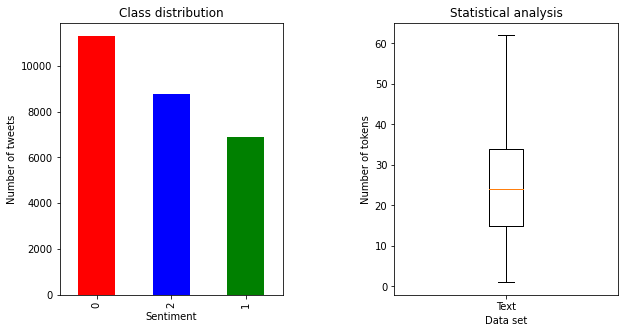

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1,ncols=2)
df['label'].value_counts().plot(ax=axes[0],subplots=True, kind='bar', color=["red", "blue", "green"], x="label", figsize=(5, 3))
axes[0].title.set_text('Class distribution')
axes[0].set_xlabel('Sentiment')
axes[0].set_ylabel('Number of tweets')

# Token lengths for all speeches
# for box plot
len_tokens = []
for text in df['Text']:
  t = tokenizer(text)
  len_tokens.append(len(t["input_ids"])-2)

fig.subplots_adjust(wspace=0.5)
fig.set_figheight(5)
fig.set_figwidth(10)

data = [len_tokens]
axes[1].set_title('Statistical analysis')
axes[1].boxplot(data, showfliers=False, labels=["Text"])
axes[1].set_ylabel("Number of tokens")
axes[1].set_xlabel("Data set")

plt.show()

# 8. Setup for Pytorch

In [ ]:
import torch

class TweetsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
train_dataset = TweetsDataset(train_encodings, train_labels)
test_dataset = TweetsDataset(test_encodings, test_labels)

# 9. Example

In [ ]:
train_dataset.__getitem__(21)

{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'input_ids': tensor([    0, 13123,  1206,  1243, 17926,   281, 20419, 13572,  4056, 15264,
           282,  3565

# 10. Adapt Pre-trained Bert

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weights = compute_class_weight('balanced', classes = np.unique(train_labels), y = train_labels)

In [ ]:
weights = torch.tensor(class_weights, dtype = torch.float)
weights = weights.cuda()

In [ ]:
weights

tensor([0.8086, 1.2982, 1.0071], device='cuda:0')

In [ ]:
from torch import nn

class CustomBERTModel(nn.Module):
    def __init__(self):
        super(CustomBERTModel, self).__init__()
        self.num_labels = 3

        self.bert = AutoModel.from_pretrained('roberta-base')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(768, 3)

    def forward(
        self,
        input_ids=None,
        attention_mask=None,
        #token_type_ids=None,
        #position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        """
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size,)`, `optional`):
            Labels for computing the sequence classification/regression loss. Indices should be in :obj:`[0, ...,
            config.num_labels - 1]`. If :obj:`config.num_labels == 1` a regression loss is computed (Mean-Square loss),
            If :obj:`config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            #token_type_ids=token_type_ids,
            #position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        #pooled_output = outputs[1]
        pooled_output = outputs[0]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        # Class weights
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        output = (logits,) + outputs[2:]


        return ((loss,) + output) if loss is not None else output

# 11. Training

In [ ]:
from transformers import Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report

In [ ]:
model = CustomBERTModel()
model = model.cuda()

In [ ]:
class_reports = []

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    cr = classification_report(labels, preds)
    print(cr)
    class_reports.append(cr)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [ ]:
epochs = 6
batch_size = 8
warm_steps = int(len(train_texts)*0.1/batch_size*epochs)

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',                      # output directory
    num_train_epochs=epochs,                         # total number of training epochs
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=batch_size,      # batch size per device during training
    per_device_eval_batch_size=batch_size,       # batch size for evaluation
    warmup_steps=warm_steps,                     # number of warmup steps for learning rate scheduler
    weight_decay=0.01,                           # strength of weight decay
    logging_dir='./logs',                        # directory for storing logs
    logging_steps=10,
    save_steps=1082,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=model,                          # the instantiated 🤗 Transformers model to be trained
    args=training_args,                   # training arguments, defined above
    train_dataset=train_dataset,          # training dataset
    eval_dataset=test_dataset,             # evaluation dataset
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

***** Running training *****
  Num examples = 21599
  Num Epochs = 6
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 16200


ValueError: ignored

In [ ]:
torch.save(model.state_dict(), './model_c_t_3.pth')

In [ ]:
# save the model as well please as the training time is v. high 